In [26]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv("air_system_previous_years.csv")

In [3]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
train_data, test_data = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["class"]
)

In [ ]:
def replace_na(df):
    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].replace("na", np.nan)

    for column in df.columns:
        if df[column].dtype == "object" and df[column].name != "class":
            df[column] = df[column].astype("float")
    return df


std_scaler = StandardScaler()

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif


# Função para trocar textos 'na' perdidos pelo nulo oficial da matemática (NaN)
def uniformizar_nulos(X):
    # O replace lida com 'na' e você pode adicionar outras sujeiras se precisar
    return X.replace(["na", "NA", "n/a", "?"], np.nan)


class FiltroInteligenteAvancado(BaseEstimator, TransformerMixin):
    def __init__(
        self, target_col="class", limite_colinearidade=0.85, min_mi_target=0.01
    ):
        self.target_col = target_col
        self.limite_colinearidade = limite_colinearidade

        # O limiar agora é de Informação Mútua (MI). MI varia de 0 a infinito.
        # 0 significa que a feature não traz informação nenhuma sobre o target.
        self.min_mi_target = min_mi_target
        self.colunas_para_manter_ = None
        self.scores_mi_ = {}  # Vamos salvar os scores para você poder analisar depois

    def fit(self, X, y=None):
        target = X[self.target_col]
        features = X.drop(columns=[self.target_col])

        # ==========================================================
        # 1. FILTRO DE RELEVÂNCIA (Feature vs Target) - Mutual Information
        # ==========================================================
        # random_state garante que o cálculo seja reproduzível
        mi_scores = mutual_info_classif(features, target, random_state=42)
        mi_series = pd.Series(mi_scores, index=features.columns)

        # Salvando os scores para debug/análise do usuário
        self.scores_mi_ = mi_series.sort_values(ascending=False).to_dict()

        # Mantém apenas features com um ganho de informação considerável
        features_relevantes = mi_series[mi_series >= self.min_mi_target].index.tolist()

        if not features_relevantes:
            raise ValueError(
                "Nenhuma feature atingiu a Informação Mútua mínima com o target."
            )

        # ==========================================================
        # 2. FILTRO DE COLINEARIDADE (Feature vs Feature) - Spearman
        # ==========================================================
        X_relevante = features[features_relevantes]

        # Usamos 'spearman' em vez do padrão 'pearson' para pegar colinearidade não-linear
        matriz_corr = X_relevante.corr(method="spearman").abs()

        triangulo_superior = matriz_corr.where(
            np.triu(np.ones(matriz_corr.shape), k=1).astype(bool)
        )

        colunas_para_dropar = [
            col
            for col in triangulo_superior.columns
            if any(triangulo_superior[col] > self.limite_colinearidade)
        ]

        # ==========================================================
        # 3. RESULTADO FINAL
        # ==========================================================
        features_finais = [
            col for col in features_relevantes if col not in colunas_para_dropar
        ]
        self.colunas_para_manter_ = features_finais + [self.target_col]

        return self

    def transform(self, X):
        return X[self.colunas_para_manter_]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer  # <-- Adicione esta importação

# =====================================================================
# 2. MONTAGEM DO PIPELINE
# =====================================================================

# Pega os nomes das features (tudo menos a classe)
features = [col for col in train_data.columns if col != "class"]

# Pipeline de Features: Uniformiza Nulos -> Preenche com Mediana -> Escala
feature_pipeline = make_pipeline(
    FunctionTransformer(uniformizar_nulos),
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

# Transformador do Target ('neg' vira 0, 'pos' vira 1)
target_encoder = OrdinalEncoder(categories=[["neg", "pos"]])

# Transformador de Colunas
preprocessor = make_column_transformer(
    (feature_pipeline, features),
    (target_encoder, ["class"]),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# O Super Pipeline Final
pipeline_final = Pipeline(
    [
        ("preparacao", preprocessor),
        (
            "selecao_features",
            FiltroInteligenteAvancado(
                target_col="class", limite_colinearidade=0.85, min_mi_target=0.01
            ),
        ),
    ]
)

# =====================================================================
# 3. EXECUÇÃO (TREINO E TESTE)
# =====================================================================

# Treina as regras e transforma os dados de TREINO
train_data_transformed = pipeline_final.fit_transform(train_data)

# Aplica as EXATAS MESMAS regras nos dados de TESTE (sem vazar dados!)
test_data_transformed = pipeline_final.transform(test_data)

print("✅ Pipeline executado com sucesso!")
print(f"Colunas originais: {train_data.shape[1]}")
print(f"Colunas mantidas após o filtro: {train_data_transformed.shape[1]}")

✅ Pipeline executado com sucesso!
Colunas originais: 171
Colunas mantidas após o filtro: 53


In [83]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# =====================================================================
# NOVO TRANSFORMADOR: PCA que respeita a coluna Target
# =====================================================================
class PCaSeguro(BaseEstimator, TransformerMixin):
    def __init__(self, target_col="class", n_components=0.95):
        self.target_col = target_col
        self.n_components = n_components
        # Inicializa o PCA real do scikit-learn
        self.pca = PCA(n_components=self.n_components, random_state=42)

    def fit(self, X, y=None):
        # Separa as features do target para treinar o PCA sem roubar
        features = X.drop(columns=[self.target_col])
        self.pca.fit(features)
        return self

    def transform(self, X):
        # Separa na hora de transformar
        features = X.drop(columns=[self.target_col])

        # Aplica o PCA nas features (retorna um Numpy Array)
        features_pca = self.pca.transform(features)

        # Reconstrói um Pandas DataFrame bonitinho (pca_0, pca_1, pca_2...)
        nomes_colunas = [f"pca_{i}" for i in range(features_pca.shape[1])]
        df_final = pd.DataFrame(features_pca, columns=nomes_colunas, index=X.index)

        # Cola a coluna target de volta intacta!
        df_final[self.target_col] = X[self.target_col]

        return df_final


# =====================================================================
# MONTAGEM DO SUPER PIPELINE FINAL
# =====================================================================
# (Aviso: Estou assumindo que a variável `preprocessor` criada nos passos
# anteriores já está rodada e pronta na sua memória)

pipeline_final = Pipeline(
    [
        ("preparacao", preprocessor),
        # Etapa 1: Corta as colunas irrelevantes e redundantes
        (
            "selecao_features",
            FiltroInteligenteAvancado(
                target_col="class", limite_colinearidade=0.85, min_mi_target=0.01
            ),
        ),
        # Etapa 2: Comprime as features sobreviventes com o PCA Seguro
        (
            "compressao_pca",
            PCaSeguro(
                target_col="class",
                n_components=0.95,  # Mantém 95% da informação matemática original
            ),
        ),
    ]
)

# =====================================================================
# EXECUÇÃO (TREINO E TESTE)
# =====================================================================
print("⏳ Rodando o Pipeline com Filtro MI/Spearman + PCA...")

train_data_transformed = pipeline_final.fit_transform(train_data)
test_data_transformed = pipeline_final.transform(test_data)

print("✅ Pipeline executado com sucesso!")
print(f"Colunas originais: {train_data.shape[1]}")
print(f"Colunas após PCA: {train_data_transformed.shape[1]}")
print("\nUma espiada nos dados finais prontos para o AutoGluon:")
display(train_data_transformed.head())

⏳ Rodando o Pipeline com Filtro MI/Spearman + PCA...


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/U

✅ Pipeline executado com sucesso!
Colunas originais: 171
Colunas após PCA: 35

Uma espiada nos dados finais prontos para o AutoGluon:


/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/dec

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,class
39839,-0.627742,-0.357352,-0.129111,-0.279114,-0.090622,0.388091,-1.233446,0.141929,-0.051922,-0.135853,...,0.256568,0.138257,-0.149244,-0.055994,0.318377,0.037118,-0.304984,0.434292,-0.064276,0.0
57649,-1.264611,-0.503204,-0.847198,-0.168892,-0.415984,-0.050130,-1.017143,0.125543,-0.102200,-0.078816,...,-0.000262,-0.012574,-0.039659,0.032187,-0.092736,-0.032860,0.019732,0.026739,0.036182,0.0
11862,-1.150645,-0.506555,-0.675513,-0.103468,-0.267220,-0.008619,-0.560009,0.095292,-0.029431,-0.098898,...,-0.007890,-0.035520,-0.092457,-0.004323,-0.161182,-0.031911,0.022200,-0.034800,-0.075044,0.0
9381,-0.483732,-0.643724,0.271804,0.160318,0.741051,-0.044989,1.860485,-0.690465,0.135407,1.022966,...,-0.199680,-0.108227,0.031407,-0.114674,-0.152745,-0.157930,0.060048,-0.296194,-0.792978,0.0
43612,-1.076276,-0.497598,-0.769463,-0.053421,-0.227619,0.004731,-0.415282,0.133232,-0.054833,-0.198242,...,0.000268,0.102521,-0.015655,-0.001259,-0.189817,-0.019215,0.061316,0.078313,0.104337,0.0


In [84]:
# --- 1. Treinamento ---
print("🚀 Iniciando o treinamento AutoML...")
predictor = TabularPredictor(
    label="class", problem_type="binary", eval_metric="f1"
).fit(
    train_data_transformed,
    presets="best_quality",  # Alterado para o preset oficial padrão ouro
    time_limit=200,
)

# --- 2. Avaliação Geral ---
print("\n" + "=" * 50)
print("📊 1. MÉTRICAS GERAIS (DADOS DE TESTE)")
print("=" * 50)
performance = predictor.evaluate(test_data_transformed, detailed_report=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20260219_005733"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:08:48 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8132
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       5.89 GB / 16.00 GB (36.8%)
Disk Space Avail:   373.83 GB / 460.43 GB (81.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyS

🚀 Iniciando o treinamento AutoML...


Beginning AutoGluon training ... Time limit = 50s
AutoGluon will save models to "/Users/gabrielsales/Documents/Projetos/tpot_examspred/AutogluonModels/ag-20260219_005733/ds_sub_fit/sub_fit_ho"
Train Data Rows:    42666
Train Data Columns: 34
Label Column:       class
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6016.08 MB
	Train Data (Original)  Memory Usage: 11.07 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting Dr


📊 1. MÉTRICAS GERAIS (DADOS DE TESTE)



🎯 4. PREVISÕES E MATRIZ DE CONFUSÃO
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     11800
         1.0       0.84      0.66      0.74       200

    accuracy                           0.99     12000
   macro avg       0.91      0.83      0.87     12000
weighted avg       0.99      0.99      0.99     12000



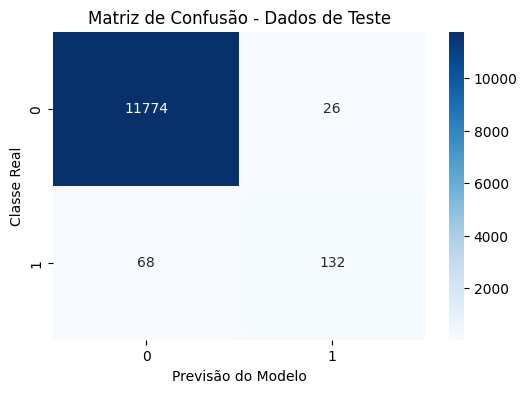


⚙️ 5. METADADOS DAS FEATURES (ENGENHARIA DO AUTOGLUON)
('float', []) : 34 | ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', ...]


In [85]:
# # --- 3. O Placar de Modelos (Leaderboard) ---
# print("\n" + "=" * 50)
# print("🏆 2. LEADERBOARD (RANKING DOS MODELOS)")
# print("=" * 50)
# # Mostra todos os modelos treinados, o score de cada um e o tempo que levaram
# leaderboard = predictor.leaderboard(test_data_transformed, extra_info=True, silent=True)
# display(leaderboard[["model", "score_test", "score_val", "fit_time"]])

# # --- 4. Importância das Features ---
# print("\n" + "=" * 50)
# print("🧠 3. IMPORTÂNCIA DAS FEATURES (O QUE O MODELO MAIS USOU?)")
# print("=" * 50)
# # Calcula a importância por permutação (pode demorar alguns segundos)
# importancia_features = predictor.feature_importance(test_data_transformed)
# display(
#     importancia_features[["importance", "stddev", "p_value"]].head(10)
# )  # Mostra as Top 10

# --- 5. Análise de Acertos e Erros (Matriz de Confusão) ---
print("\n" + "=" * 50)
print("🎯 4. PREVISÕES E MATRIZ DE CONFUSÃO")
print("=" * 50)

# Pega as previsões reais feitas pelo melhor modelo
y_pred = predictor.predict(test_data_transformed)
y_true = test_data_transformed["class"]

# Gera a Matriz de Confusão usando o scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Relatório detalhado de Precision, Recall e F1
print(classification_report(y_true, y_pred))

# BÔNUS VISUAL: Plota a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=predictor.class_labels,
    yticklabels=predictor.class_labels,
)
plt.title("Matriz de Confusão - Dados de Teste")
plt.ylabel("Classe Real")
plt.xlabel("Previsão do Modelo")
plt.show()

# --- 6. Metadados das Features ---
print("\n" + "=" * 50)
print("⚙️ 5. METADADOS DAS FEATURES (ENGENHARIA DO AUTOGLUON)")
print("=" * 50)
print(predictor.feature_metadata)

📊 TAXA DE POSITIVOS POR DECIL
       Treino   Teste
Decil                
0       0.00%   0.00%
1       0.00%   0.00%
2       0.00%   0.00%
3       0.00%   0.00%
4       0.00%   0.00%
5       0.00%   0.00%
6       0.00%   0.00%
7       0.00%   0.08%
8       0.00%   0.08%
9      16.67%  16.50%
------------------------------


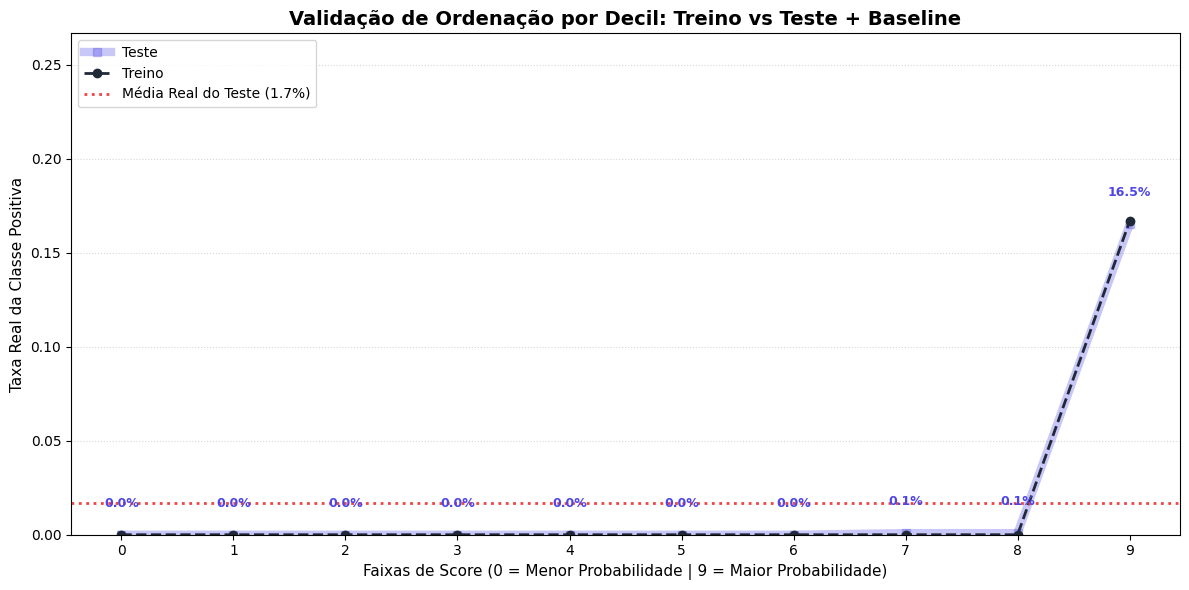

In [86]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_ordenacao_completa(predictor, train_data, test_data, label):
    # 1. Calculando scores
    probs_train = predictor.predict_proba(train_data).iloc[:, 1].values
    probs_test = predictor.predict_proba(test_data).iloc[:, 1].values

    # 2. Criando DataFrames
    df_train = pd.DataFrame({"Real": train_data[label].values, "Score": probs_train})
    df_test = pd.DataFrame({"Real": test_data[label].values, "Score": probs_test})

    # 3. Criando os Decis
    df_train["Decil"] = pd.qcut(df_train["Score"], 10, labels=False, duplicates="drop")
    df_test["Decil"] = pd.qcut(df_test["Score"], 10, labels=False, duplicates="drop")

    # 4. Médias por Decil
    rank_train = df_train.groupby("Decil")["Real"].mean().sort_index()
    rank_test = df_test.groupby("Decil")["Real"].mean().sort_index()

    # --- PROVA REAL: Imprimindo os números ---
    print("📊 TAXA DE POSITIVOS POR DECIL")
    tabela_comparativa = pd.DataFrame(
        {"Treino": rank_train, "Teste": rank_test}
    ).fillna(0)
    # Formata como porcentagem para facilitar a leitura
    print(tabela_comparativa.map(lambda x: f"{x:.2%}"))
    print("-" * 30)

    # 5. Média Global
    media_global = test_data[label].mean()

    # 6. Plotagem
    plt.figure(figsize=(12, 6))

    # --- CORREÇÃO DO ECLIPSE ---
    # Passo A: Plotar o TESTE primeiro (Azul, grosso, mas meio transparente)
    plt.plot(
        rank_test.index.astype(str),
        rank_test.values,
        marker="s",
        linestyle="-",
        color="#4f46e5",
        label="Teste",
        linewidth=6,  # Ainda mais grosso para servir de sombra
        alpha=0.3,  # Transparente para deixar o treino aparecer!
    )

    # Passo B: Plotar o TREINO por cima (Cinza escuro, nítido)
    plt.plot(
        rank_train.index.astype(str),
        rank_train.values,
        marker="o",
        linestyle="--",
        color="#1f2937",  # Um cinza bem escuro para dar contraste
        label="Treino",
        linewidth=2,
    )

    # LINHA DA MÉDIA
    plt.axhline(
        y=media_global,
        color="#ef4444",
        linestyle=":",
        linewidth=2,
        label=f"Média Real do Teste ({media_global:.1%})",
    )

    plt.title(
        "Validação de Ordenação por Decil: Treino vs Teste + Baseline",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel(
        "Faixas de Score (0 = Menor Probabilidade | 9 = Maior Probabilidade)",
        fontsize=11,
    )
    plt.ylabel("Taxa Real da Classe Positiva", fontsize=11)
    plt.ylim(
        0, max(rank_train.max(), rank_test.max()) + 0.1
    )  # Ajusta o teto do gráfico dinamicamente
    plt.legend(loc="upper left")
    plt.grid(axis="y", linestyle=":", alpha=0.5)

    # Rótulos de dados apenas na linha de Teste
    for i, val in enumerate(rank_test.values):
        plt.text(
            i,
            val + 0.015,
            f"{val:.1%}",
            ha="center",
            fontsize=9,
            color="#4f46e5",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


# Roda a função novamente
plot_ordenacao_completa(
    predictor, train_data_transformed, test_data_transformed, label="class"
)

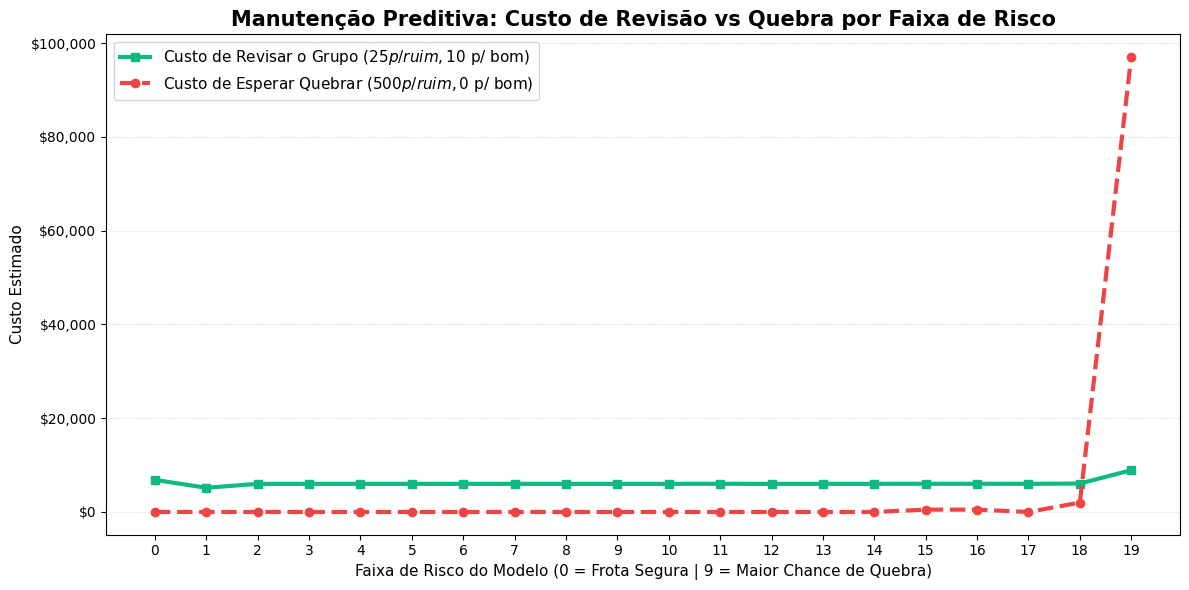

📊 POLÍTICA ÓTIMA DE MANUTENÇÃO POR FAIXA DE RISCO


,Total_Veiculos,Veiculos_Problematicos,Custo_Revisar_Todos,Custo_Nao_Revisar,Ação Recomendada,Economia_Gerada
Decil,,,,,,
0,684,0.0,"$6,840.00",$0.00,✅ LIBERAR VEÍCULO,"$6,840.00"
1,516,0.0,"$5,160.00",$0.00,✅ LIBERAR VEÍCULO,"$5,160.00"
2,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
3,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
4,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
5,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
6,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
7,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"
8,600,0.0,"$6,000.00",$0.00,✅ LIBERAR VEÍCULO,"$6,000.00"


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker


def plot_custos_manutencao_decil(
    predictor,
    test_data,
    label,
    custo_tn=0,
    custo_tp=25,
    custo_fn=500,
    custo_fp=10,
    faixas=10,
):
    # 1. Pegando as probabilidades e o gabarito real dos dados de TESTE
    probs_test = predictor.predict_proba(test_data).iloc[:, 1].values

    if test_data[label].dtype == "object" or test_data[label].dtype.name == "category":
        y_true = (test_data[label] == "pos").astype(int).values
    else:
        y_true = test_data[label].values

    # 2. Criando o DataFrame
    df_test = pd.DataFrame({"Real": y_true, "Score": probs_test})

    # 3. Criando os Decis (0 = Menor risco de quebra | 9 = Maior risco de quebra)
    df_test["Decil"] = pd.qcut(
        df_test["Score"], faixas, labels=False, duplicates="drop"
    )

    # 4. Agrupando para calcular a MATRIZ DE CUSTOS REAL por Decil
    resumo_decil = df_test.groupby("Decil").agg(
        Total_Veiculos=("Real", "count"), Veiculos_Problematicos=("Real", "sum")
    )

    resumo_decil["Veiculos_Bons"] = (
        resumo_decil["Total_Veiculos"] - resumo_decil["Veiculos_Problematicos"]
    )

    # =========================================================================
    # 5. O MOTOR FINANCEIRO (Sua Matriz de Custos)
    # =========================================================================

    # CENÁRIO A (AÇÃO): Se mandarmos TODOS deste decil para a revisão preventiva
    # Pagamos $25 (TP) nos que realmente precisavam + $10 (FP) nos que estavam bons
    resumo_decil["Custo_Revisar_Todos"] = (
        resumo_decil["Veiculos_Problematicos"] * custo_tp
    ) + (resumo_decil["Veiculos_Bons"] * custo_fp)

    # CENÁRIO B (OMISSÃO): Se NÃO mandarmos NINGUÉM deste decil para a revisão
    # Pagamos $500 (FN) pela quebra na rua dos ruins + $0 (TN) nos que estavam bons
    resumo_decil["Custo_Nao_Revisar"] = (
        resumo_decil["Veiculos_Problematicos"] * custo_fn
    ) + (resumo_decil["Veiculos_Bons"] * custo_tn)

    # =========================================================================
    # 6. PLOTAGEM EXECUTIVA
    # =========================================================================
    plt.figure(figsize=(12, 6))

    # Linha Verde: Custo de ser Proativo (Revisar)
    plt.plot(
        resumo_decil.index.astype(str),
        resumo_decil["Custo_Revisar_Todos"],
        marker="s",
        linestyle="-",
        color="#10b981",
        linewidth=3,
        label=f"Custo de Revisar o Grupo ($25 p/ ruim, $10 p/ bom)",
    )

    # Linha Vermelha: Custo de ser Reativo (Esperar Quebrar)
    plt.plot(
        resumo_decil.index.astype(str),
        resumo_decil["Custo_Nao_Revisar"],
        marker="o",
        linestyle="--",
        color="#ef4444",
        linewidth=3,
        label=f"Custo de Esperar Quebrar ($500 p/ ruim, $0 p/ bom)",
    )

    plt.title(
        "Manutenção Preditiva: Custo de Revisão vs Quebra por Faixa de Risco",
        fontsize=15,
        fontweight="bold",
    )
    plt.xlabel(
        "Faixa de Risco do Modelo (0 = Frota Segura | 9 = Maior Chance de Quebra)",
        fontsize=11,
    )
    plt.ylabel("Custo Estimado", fontsize=11)

    formatter = ticker.FuncFormatter(lambda x, pos: f"${x:,.0f}")
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.legend(loc="upper left", fontsize=11)
    plt.grid(axis="y", linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # =========================================================================
    # 7. TABELA DE DECISÃO FINAL (A "REGRA DE NEGÓCIO")
    # =========================================================================
    print("📊 POLÍTICA ÓTIMA DE MANUTENÇÃO POR FAIXA DE RISCO")
    tabela_display = resumo_decil.copy()

    # A regra é implacável: Faça o que for mais barato para a empresa.
    tabela_display["Ação Recomendada"] = tabela_display.apply(
        lambda row: (
            "🔧 MANDAR P/ REVISÃO"
            if row["Custo_Nao_Revisar"] > row["Custo_Revisar_Todos"]
            else "✅ LIBERAR VEÍCULO"
        ),
        axis=1,
    )

    # Calculando a economia gerada se seguirmos a IA em vez de agir às cegas
    tabela_display["Economia_Gerada"] = abs(
        tabela_display["Custo_Nao_Revisar"] - tabela_display["Custo_Revisar_Todos"]
    )

    # Formatando para exibição
    for col in ["Custo_Revisar_Todos", "Custo_Nao_Revisar", "Economia_Gerada"]:
        tabela_display[col] = tabela_display[col].apply(lambda x: f"${x:,.2f}")

    display(
        tabela_display[
            [
                "Total_Veiculos",
                "Veiculos_Problematicos",
                "Custo_Revisar_Todos",
                "Custo_Nao_Revisar",
                "Ação Recomendada",
                "Economia_Gerada",
            ]
        ]
    )


# Roda a função com os SEUS custos exatos
plot_custos_manutencao_decil(
    predictor,
    test_data_transformed,
    label="class",
    custo_tn=0,  # Veículo bom liberado = Sem custo
    custo_tp=25,  # Manutenção preventiva no veículo ruim = $25
    custo_fn=500,  # Deixou passar e quebrou na rua = $500
    custo_fp=10,  # Parou veículo bom à toa = $10
    faixas=20,
)

In [ ]:
import pandas as pd
import numpy as np

# 1. Calculando as probabilidades nos dados de teste que você já tem
# (Certifique-se de que test_data_transformed já passou pelo seu pipeline)
probs_teste = predictor.predict_proba(test_data_transformed).iloc[:, 1]

# 2. Criando o DataFrame de Avaliação
df_teste_final = test_data_transformed.copy()
df_teste_final["prob_falha"] = probs_teste

# 3. Criando as 20 Faixas (Vigintis)
# Usamos labels=False para ter os IDs de 0 a 19
df_teste_final["faixa_id"] = pd.qcut(
    df_teste_final["prob_falha"], 20, labels=False, duplicates="drop"
)


# 4. Definindo a Regra de Negócio baseada na sua tabela de ROI
# Faixa 19 = Economia de $88k (Crítico)
# Faixas 15-18 = Casos isolados (Alerta)
def definir_status(faixa):
    if faixa == 19:
        return "🔴 CRÍTICO: Manutenção Imediata"
    elif 15 <= faixa <= 18:
        return "🟡 ALERTA: Monitorar Próximos Dias"
    else:
        return "🟢 SEGURO: Operação Normal"


df_teste_final["recomendacao_operacional"] = df_teste_final["faixa_id"].apply(
    definir_status
)


# 5. Calculando o custo por veículo baseado na sua Matriz de Custos
# TP: $25 | FN: $500 | FP: $10 | TN: $0
def calcular_custo_estimado(row):
    # Se mandarmos para revisão (Categorias Vermelha e Amarela)
    if row["recomendacao_operacional"] != "🟢 SEGURO: Operação Normal":
        return 25 if row["class"] == "pos" else 10
    # Se liberarmos (Categoria Verde)
    else:
        return 500 if row["class"] == "pos" else 0


df_teste_final["custo_decisao_ia"] = df_teste_final.apply(
    calcular_custo_estimado, axis=1
)

# 6. Exibindo o Resultado Final
print("📊 RESULTADO DO TESTE COM O PREDICTOR ATUAL")
print("-" * 50)
resumo = df_teste_final.groupby("recomendacao_operacional").agg(
    veiculos=("prob_falha", "count"), custo_total=("custo_decisao_ia", "sum")
)
print(resumo)

print(
    f"\n💰 CUSTO TOTAL ESTIMADO COM ESSA ESTRATÉGIA: ${df_teste_final['custo_decisao_ia'].sum():,.2f}"
)
print("-" * 50)

# 7. Ver os top 10 veículos que a oficina deve focar
print("\n📋 LISTA DE PRIORIDADE (TOP 10 RISCOS):")
display(
    df_teste_final.sort_values("prob_falha", ascending=False)[
        ["prob_falha", "faixa_id", "recomendacao_operacional", "class"]
    ].head(10)
)

/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/U

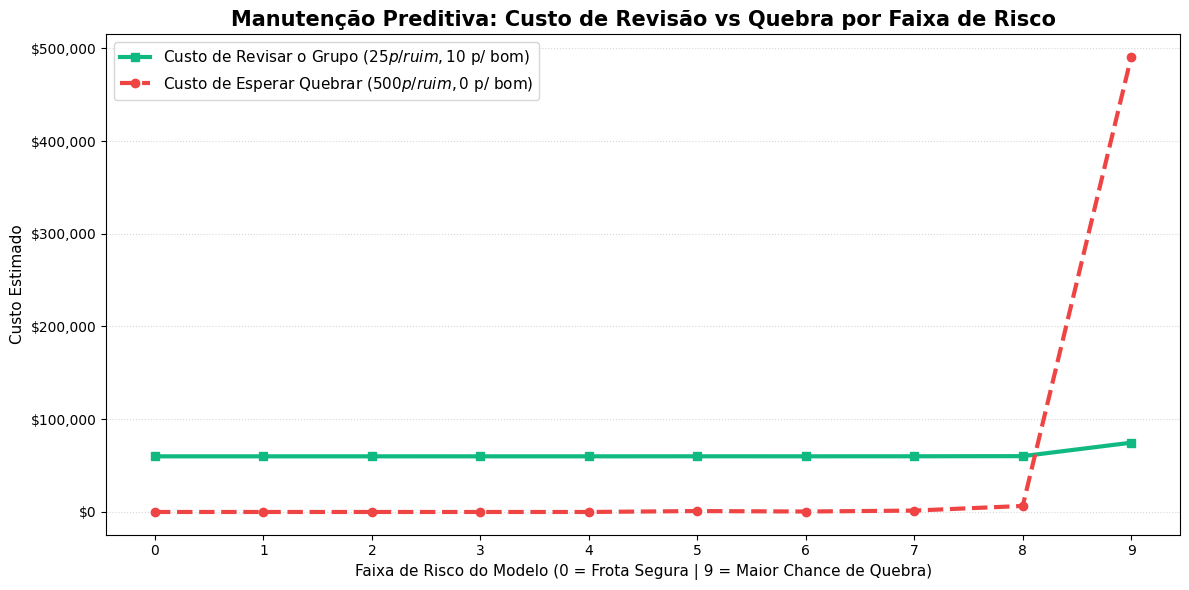

📊 POLÍTICA ÓTIMA DE MANUTENÇÃO POR FAIXA DE RISCO


,Total_Veiculos,Veiculos_Problematicos,Custo_Revisar_Todos,Custo_Nao_Revisar,Ação Recomendada,Economia_Gerada
Decil,,,,,,
0,6000,0.0,"$60,000.00",$0.00,✅ LIBERAR VEÍCULO,"$60,000.00"
1,6000,0.0,"$60,000.00",$0.00,✅ LIBERAR VEÍCULO,"$60,000.00"
2,6001,0.0,"$60,010.00",$0.00,✅ LIBERAR VEÍCULO,"$60,010.00"
3,5999,0.0,"$59,990.00",$0.00,✅ LIBERAR VEÍCULO,"$59,990.00"
4,6000,0.0,"$60,000.00",$0.00,✅ LIBERAR VEÍCULO,"$60,000.00"
5,6000,2.0,"$60,030.00","$1,000.00",✅ LIBERAR VEÍCULO,"$59,030.00"
6,6000,1.0,"$60,015.00",$500.00,✅ LIBERAR VEÍCULO,"$59,515.00"
7,6001,3.0,"$60,055.00","$1,500.00",✅ LIBERAR VEÍCULO,"$58,555.00"
8,5999,13.0,"$60,185.00","$6,500.00",✅ LIBERAR VEÍCULO,"$53,685.00"


In [90]:
all_data_transformed = df.copy()
all_data_transformed = pipeline_final.fit_transform(all_data_transformed)
# Roda a função com os SEUS custos exatos
plot_custos_manutencao_decil(
    predictor,
    all_data_transformed,
    label="class",
    custo_tn=0,  # Veículo bom liberado = Sem custo
    custo_tp=25,  # Manutenção preventiva no veículo ruim = $25
    custo_fn=500,  # Deixou passar e quebrou na rua = $500
    custo_fp=10,  # Parou veículo bom à toa = $10
)

/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/gabrielsales/Documents/Projetos/tpot_examspred/.venv/lib/python3.10/site-packages/sklearn/dec

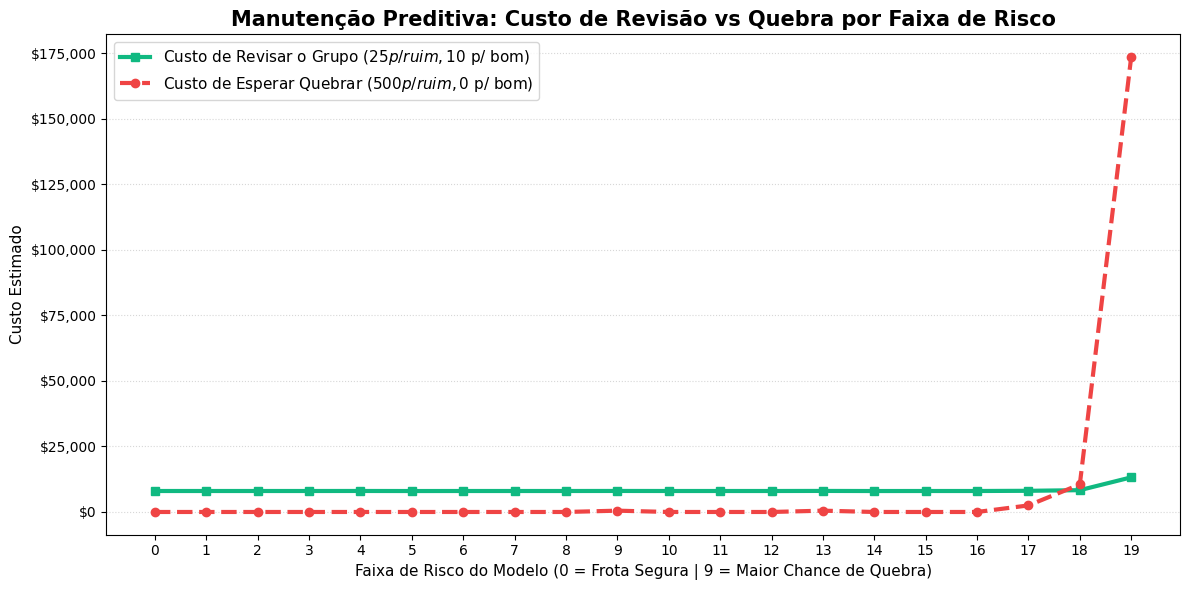

📊 POLÍTICA ÓTIMA DE MANUTENÇÃO POR FAIXA DE RISCO


,Total_Veiculos,Veiculos_Problematicos,Custo_Revisar_Todos,Custo_Nao_Revisar,Ação Recomendada,Economia_Gerada
Decil,,,,,,
0,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
1,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
2,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
3,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
4,801,0.0,"$8,010.00",$0.00,✅ LIBERAR VEÍCULO,"$8,010.00"
5,799,0.0,"$7,990.00",$0.00,✅ LIBERAR VEÍCULO,"$7,990.00"
6,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
7,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"
8,800,0.0,"$8,000.00",$0.00,✅ LIBERAR VEÍCULO,"$8,000.00"


In [ ]:
df_teste_present = pd.read_csv("air_system_present_year.csv")
test_data_transformed_present = pipeline_final.transform(df_teste_present)

# Pega as previsões reais feitas pelo melhor modelo
# y_pred = predictor.predict(test_data_transformed_present)
# y_true = test_data_transformed_present["class"]

# Roda a função com os SEUS custos exatos
plot_custos_manutencao_decil(
    predictor,
    test_data_transformed_present,
    label="class",
    custo_tn=0,  # Veículo bom liberado = Sem custo
    custo_tp=25,  # Manutenção preventiva no veículo ruim = $25
    custo_fn=500,  # Deixou passar e quebrou na rua = $500
    custo_fp=10,
    faixas=20,  # Parou veículo bom à toa = $10
)
# # Gera a Matriz de Confusão usando o scikit-learn
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Relatório detalhado de Precision, Recall e F1
# print(classification_report(y_true, y_pred))

# # BÔNUS VISUAL: Plota a Matriz de Confusão
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=predictor.class_labels,
#     yticklabels=predictor.class_labels,
# )
# plt.title("Matriz de Confusão - Dados de Teste")
# plt.ylabel("Classe Real")
# plt.xlabel("Previsão do Modelo")
# plt.show()

# # --- 6. Metadados das Features ---
# print("\n" + "=" * 50)
# print("⚙️ 5. METADADOS DAS FEATURES (ENGENHARIA DO AUTOGLUON)")
# print("=" * 50)
# print(predictor.feature_metadata)

In [103]:
import pandas as pd
import numpy as np

# 1. Calculando as probabilidades nos dados de teste que você já tem
# (Certifique-se de que test_data_transformed já passou pelo seu pipeline)
probs_teste = predictor.predict_proba(test_data_transformed_present).iloc[:, 1]

# 2. Criando o DataFrame de Avaliação
df_teste_final = test_data_transformed_present.copy()
df_teste_final["prob_falha"] = probs_teste

# 3. Criando as 20 Faixas (Vigintis)
# Usamos labels=False para ter os IDs de 0 a 19
df_teste_final["faixa_id"] = pd.qcut(
    df_teste_final["prob_falha"], 20, labels=False, duplicates="drop"
)


# 4. Definindo a Regra de Negócio baseada na sua tabela de ROI
# Faixa 19 = Economia de $88k (Crítico)
# Faixas 15-18 = Casos isolados (Alerta)
def definir_status_otimizado(faixa):
    # Focamos APENAS onde o volume de problemas justifica o gasto com vistorias
    if faixa >= 18:
        return "🔴 CRÍTICO: Manutenção Imediata"
    # A faixa 17 e 18 agora são consideradas "Risco Aceitável"
    else:
        return "🟢 SEGURO: Operação Normal"


df_teste_final["recomendacao_operacional"] = df_teste_final["faixa_id"].apply(
    definir_status_otimizado
)


def calcular_custo_real(row):
    # Esta linha garante que 'pos', 1, ou '1' sejam lidos como positivo
    e_positivo = str(row["class"]).strip().lower() in ["pos", "1", "1.0"]

    # Se mandamos para revisão (CRÍTICO ou ALERTA)
    if row["recomendacao_operacional"] != "🟢 SEGURO: Operação Normal":
        # $25 se for problema real, $10 se for alarme falso
        return 25 if e_positivo else 10

    # Se LIBERAMOS o caminhão (SEGURO)
    else:
        # $500 se quebrar na rua, $0 se estiver realmente bom
        return 500 if e_positivo else 0


df_teste_final["custo_real"] = df_teste_final.apply(calcular_custo_real, axis=1)

# Resumo Detalhado
resumo_financeiro = df_teste_final.groupby("recomendacao_operacional").agg(
    veiculos=("prob_falha", "count"),
    custo_total=("custo_real", "sum"),
    quebras_na_rua=(
        "class",
        lambda x: (
            (
                df_teste_final.loc[x.index, "recomendacao_operacional"]
                == "🟢 SEGURO: Operação Normal"
            )
            & (x == "pos")
        ).sum(),
    ),
)
print(resumo_financeiro)
print(f"\n💰 CUSTO TOTAL REAL ESTIMADO: ${df_teste_final['custo_real'].sum():,.2f}")

                                veiculos  custo_total  quebras_na_rua
recomendacao_operacional                                             
🔴 CRÍTICO: Manutenção Imediata      1600        21520               0
🟢 SEGURO: Operação Normal          14400         3500               0

💰 CUSTO TOTAL REAL ESTIMADO: $25,020.00
